## Image Caption Generation

### Motivation 
> 1. Understand the principles of text pre-processing and vocabulary building.
> 2. Gain experience working with an image-to-text model.
> 3. Use and compare two text similarity metrics for evaluating an image-to-text model, and understand evaluation challenges.


### Setup and resources 
I will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images of 80 object categories, and at least five textual reference captions per image. The subset consists of nearly 5070 of these images, each with five or more different descriptions of the salient entities and activities, and I will refer to it as COCO_5070.

### Imports

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
from tqdm import tqdm
from PIL import Image
import re
import nltk

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cpu


The basic principle of our image-to-text model is as follows. An Encoder network encodes the input image as a feature vector by providing the outputs of the last convolutional layer of a pre-trained CNN (I use [ResNet50](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects. 

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by *a batch normalisation layer* to speed up training. Those resulting features, as well as the reference text captions, are then passed into a recurrent network. 

The reference captions used to compute loss are represented as numerical vectors via an **embedding layer** whose weights are learned during training.

The Encoder-Decoder network could be coupled and trained end-to-end, without saving features to disk; however, this requires iterating through the entire image training set during training. We can make the **training more efficient by decoupling the networks**. Thus, I will:

> First extract the feature representations of the images from the Encoder

> Save these features (Part 1) such that during the training of the Decoder (Part 3), I only need to iterate over the image feature data and the reference captions.


### Overview
> 1. Extracting image features 
> 2. Text preparation of training and validation data 
> 3. Training the decoder
> 4. Generating predictions on test data
> 5. Caption evaluation via BLEU score
> 6. Caption evaluation via Cosine similarity
> 7. Comparing BLEU and Cosine similarity


## 1 Extracting image features

> 1.1 Design a encoder layer with pretrained ResNet50

> 1.2 Image feature extraction step

#### 1.1 Design a encoder layer with pretrained ResNet50 

> I will use ResNet50 pretrained on imageNet provided in the Pytorch library (torchvision.models)


In [2]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-50 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        
        resnet = models.resnet50(pretrained = True)
        self.resnet_layers = nn.Sequential(*list(resnet.children())[:-1]) 

    def forward(self, images):
        """Extract feature vectors from input images."""
        
        with torch.no_grad():
            features = self.resnet_layers(images)
            features = features.view(features.size(0), -1)
        return features

In [3]:
# instantiate encoder and put into evaluation mode.
# Instantiate the encoder
encoder = EncoderCNN()

# Put the encoder into evaluation mode
encoder.eval()

C:\V\Files\Anaconda\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\V\Files\Anaconda\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


EncoderCNN(
  (resnet_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Co

#### 1.2 Image feature extraction step

I will pass the images through the ```Encoder``` model, saving the resulting features for each image.

Note that as this is a forward pass only, no gradients are needed. I will need to match each image ID (the image name without file extension) with its features later, so I will be saving a dictionary of image ID: image features, or keeping a separate ordered list of image IDs.

ImageNet transform:

In [4]:
data_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Resize(224), 
    transforms.CenterCrop(224), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

In [5]:
# Get unique images from the csv for extracting features - helper code
imageList = pd.read_csv("coco_subset_meta.csv")
imageList["file_name"]
len(imageList.id.unique())

imagesUnique = sorted(imageList["file_name"].unique())
print(len(imagesUnique))

df_unique_files =  pd.DataFrame.from_dict(imagesUnique)

df_unique_files.columns = ["file_name"]
df_unique_files

5068


,file_name
0,000000000009.jpg
1,000000000025.jpg
2,000000000030.jpg
3,000000000034.jpg
4,000000000036.jpg
...,...
5063,000000581906.jpg
5064,000000581909.jpg
5065,000000581913.jpg
5066,000000581921.jpg


In [6]:
# Define a class COCOImagesDataset(Dataset) function that takes the 
# image file names and reads the image and apply transform to it

IMAGE_DIR = "coco/images/"

class COCOImagesDataset(Dataset):
    def __init__(self, df, transform = None):

        self.df = df
        self.transform = transform

    def __getitem__(self, index):
        filename = self.df.iloc[index]["file_name"]
        img_id = os.path.splitext(filename)[0]
        
        # load image using PIL and apply transform
        img_path = os.path.join(IMAGE_DIR, filename)
        img = Image.open(img_path).convert("RGB")
        if self.transform is not None:
            img = self.transform(img)               
        
        return img, img_id       

    def __len__(self):
        return len(self.df)
    

In [7]:
# Use Dataloader to use the unique files using the class COCOImagesDataset
# make sure that shuffle is False as we are not aiming to retrain 


dataset = COCOImagesDataset(df_unique_files, transform = data_transform)
dataloader = DataLoader(dataset, batch_size = 64, shuffle = False)

In [8]:
# # Apply encoder to extract featues and save them 

    
features_map = {}
 
with torch.no_grad():
    for images, filenames in tqdm(dataloader):
        features = encoder(images)
        for i in range(len(filenames)):
            filename = filenames[i]
            feature = features[i]
            features_map[filename] = feature.numpy()



100%|██████████████████████████████████████████████████████████████████████████████████| 80/80 [23:19<00:00, 17.50s/it]


In [9]:
#Save the features
torch.save(features_map, "coco_feat.pt")

In [10]:
saved_feat = torch.load("coco_feat.pt")

In [57]:
if '000000376996' in saved_feat:
    print('Key 2 found!')
else:
    print('Key 2 not found.')

Key 2 found!


## 2 Text preparation

> 2.1 Build the caption dataset

> 2.2 Clean the captions 

> 2.3 Split the data

> 2.4 Building the vocabulary

> 2.5 Prepare dataset using dataloader

#### 2.1 Build the caption dataset

Selected COCO_5029 images are from the official 2017 train set.

The ```coco_subset_meta.csv``` file includes the image filenames and unique IDs of all the images in our subset. The ```id``` column corresponds to each unique image ID.

The COCO dataset includes many different types of annotations: bounding boxes, keypoints, reference captions, and more. I am interested in the captioning labels. I will be using the ```json``` package to initially inspect the data, then the ```pandas``` package to look at the annotations.

I will use ```coco_subset_meta.csv``` to cross-reference with the annotations from ```captions_train2017.json``` to get all the reference captions for each image in COCO_5029.

In [11]:
import json

# loading captions for training
with open("coco/annotations2017/captions_train2017.json", "r") as json_file:
    data = json.load(json_file)
    
df = pd.DataFrame.from_dict(data["annotations"])
df.head()

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...


In [17]:
df.shape

(591753, 3)

In [12]:
coco_subset = pd.read_csv("coco_subset_meta.csv")
coco_subset.head()
# name the new dataframe as "new_file"
merged_data = pd.merge(df, coco_subset, left_on = "image_id", right_on = "id")


In [13]:
coco_subset.head()

,Unnamed: 0,license,file_name,coco_url,height,width,date_captured,flickr_url,id
0,0,2,000000262145.jpg,http://images.cocodataset.org/train2017/000000...,427,640,2013-11-20 02:07:55,http://farm8.staticflickr.com/7187/6967031859_...,262145
1,1,1,000000262146.jpg,http://images.cocodataset.org/train2017/000000...,640,480,2013-11-19 23:07:16,http://farm6.staticflickr.com/5090/5341741494_...,262146
2,2,3,000000524291.jpg,http://images.cocodataset.org/train2017/000000...,426,640,2013-11-18 09:59:07,http://farm2.staticflickr.com/1045/934293170_d...,524291
3,3,1,000000262148.jpg,http://images.cocodataset.org/train2017/000000...,512,640,2013-11-20 05:50:03,http://farm5.staticflickr.com/4028/4549977479_...,262148
4,4,3,000000393223.jpg,http://images.cocodataset.org/train2017/000000...,480,640,2013-11-21 20:08:57,http://farm1.staticflickr.com/28/45521803_c5cb...,393223


In [14]:
new_file = merged_data[["image_id", "id_x", "caption", "file_name"]]
new_file.columns = ["image_id", "id", "caption", "filename"]
new_file.head(10)

,image_id,id,caption,filename
0,57429,2049,An airplane with its landing wheels out landing.,000000057429.jpg
1,57429,2139,A plane that is taking off at an airport,000000057429.jpg
2,57429,2946,A man takes a picture of an airplane taking off.,000000057429.jpg
3,57429,5520,A large jet takes off from an airport runway.,000000057429.jpg
4,57429,821117,The airplane is taking off on the runway at th...,000000057429.jpg
5,410627,2961,The young man is stirring his pot of food with...,000000410627.jpg
6,410627,6444,A man enjoys cooking food in a pan,000000410627.jpg
7,410627,8523,A smiling man is cooking in his kitchen.,000000410627.jpg
8,410627,8649,A man smiles as he stirs his food in the pot.,000000410627.jpg
9,410627,826886,A boy smiles while holding a pot and spoon.,000000410627.jpg


In [15]:
new_file = new_file.drop_duplicates()

In [16]:
new_file.shape

(25349, 4)

#### 2.2 Clean the captions

In [28]:
new_file["clean_caption"] = "" # Adding a new column to the dataframe for the cleaned captions

def gen_clean_captions_df(df):

    # Removing spaces in the beginning and at the end
    # Converting to lower case
    # Replacing all non-alphabet characters with space
    # Replacing all continuous spaces with a single space

    clean_caption = []
    for caption in df["caption"]:
        cleaned = caption.lower()
        cleaned = re.sub("[^a-zA-Z]", " ", cleaned)
        cleaned = re.sub("\s+", " ", cleaned).strip()
        clean_caption.append(cleaned)

    df["clean_caption"] = clean_caption

    return df

In [39]:
# Printing 10 values from cleaned version
new_file = gen_clean_captions_df(new_file)
new_file.head(10)

,image_id,id,caption,filename,clean_caption
0,57429,2049,An airplane with its landing wheels out landing.,000000057429.jpg,an airplane with its landing wheels out landing
1,57429,2139,A plane that is taking off at an airport,000000057429.jpg,a plane that is taking off at an airport
2,57429,2946,A man takes a picture of an airplane taking off.,000000057429.jpg,a man takes a picture of an airplane taking off
3,57429,5520,A large jet takes off from an airport runway.,000000057429.jpg,a large jet takes off from an airport runway
4,57429,821117,The airplane is taking off on the runway at th...,000000057429.jpg,the airplane is taking off on the runway at th...
5,410627,2961,The young man is stirring his pot of food with...,000000410627.jpg,the young man is stirring his pot of food with...
6,410627,6444,A man enjoys cooking food in a pan,000000410627.jpg,a man enjoys cooking food in a pan
7,410627,8523,A smiling man is cooking in his kitchen.,000000410627.jpg,a smiling man is cooking in his kitchen
8,410627,8649,A man smiles as he stirs his food in the pot.,000000410627.jpg,a man smiles as he stirs his food in the pot
9,410627,826886,A boy smiles while holding a pot and spoon.,000000410627.jpg,a boy smiles while holding a pot and spoon


#### 2.3  Split the data
Split the data 70/10/20% into train/validation/test sets. (Being sure that each unique image (and all corresponding captions) only appear in a single set.)

I provide the function below which, given a list of unique image IDs and a 3-split ratio, shuffles and returns a split of the image IDs.

In [38]:
import random
import math

def split_ids(image_id_list, train = 0.7, valid = 0.1, test = 0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """
    list_copy = image_id_list.copy()
    random.shuffle(list_copy)
    
    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)
    
    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [40]:
# get the list of unique image IDs
image_ids = new_file["image_id"].unique()

# split the IDs into train/validation/test sets
train_ids, valid_ids, test_ids = split_ids(image_ids)

In [41]:
len(train_ids)

3547

In [32]:
# filter the dataframe based on the split IDs
train_data = new_file[new_file["image_id"].isin(train_ids)].reset_index(drop = True)
valid_data = new_file[new_file["image_id"].isin(valid_ids)].reset_index(drop = True)
test_data = new_file[new_file["image_id"].isin(test_ids)].reset_index(drop = True)

In [48]:
len(train_data)
len(valid_data)

2531

#### 2.4 Building the vocabulary
The vocabulary consists of all the possible words which can be used - both as input into the model, and as output predictions, and I will build it using the cleaned words found in the reference captions from the training set. In the vocabulary each unique word is mapped to a unique integer (a Python ```dictionary``` object).

In [34]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {"<pad>": 0, "<unk>": 1, "<end>": 2}
        self.idx2word = {0: "<pad>", 1: "<unk>", 2: "<end>"}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            # this will convert each word to index and index to word as you saw in the tutorials
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx["<unk>"]
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


I will collect all words from the cleaned captions in the **training and validation sets**, ignoring any words which appear 3 times or less; this should leave me with roughly 2200 words (plus or minus is fine). As the vocabulary size affects the embedding layer dimensions, it is better not to add the very infrequently used words to the vocabulary.

I will create an instance of the ```Vocabulary()``` object and add all your words to it.

In [35]:
MIN_FREQUENCY = 3

def build_vocab(df_ids, new_file):
    """ 
    Parses training set token file captions and builds a Vocabulary object and dataframe for 
    the image and caption data

    Returns:
        vocab (Vocabulary): Vocabulary object containing all words appearing more than min_frequency
    """
    word_mapping = Counter()

    # for index in df.index:
    for index, id in enumerate(df_ids):
       
        caption = str(new_file.loc[new_file["image_id"] == id]["clean_caption"])
    
        for word in caption.split():
            # also get rid of numbers, symbols etc.
            if word in word_mapping:
                word_mapping[word] += 1
            else:
                word_mapping[word] = 1

    # create a vocab instance
    vocab = Vocabulary()

    # add the words to the vocabulary
    for word in word_mapping:
        # Ignore infrequent words to reduce the embedding size
        if word_mapping[word] > MIN_FREQUENCY and word.isalpha():
            vocab.add_word(word)        

    return vocab

In [36]:
# build the vocabulary for train, valid and test sets

combined_ids = pd.concat([train_data["image_id"], valid_data["image_id"]], ignore_index = True)
combined_data = pd.concat([train_data, valid_data], ignore_index = True)
all_vocab = build_vocab(combined_ids.unique(), combined_data)
test_vocab = build_vocab(test_ids, test_data)


In [46]:
combined_data.shape

(20271, 5)

In [58]:
len(test_vocab)

986


#### 2.5 Prepare dataset using dataloader

 

I will create a PyTorch ```Dataset``` class and a corresponding ```DataLoader``` for the inputs to the decoder. Three sets: one each for training, validation, and test. Set ```shuffle=True``` for the training set DataLoader.

 

The ```Dataset``` function ```__getitem__(self, index)``` should return three Tensors:

 

>1. A Tensor of image features, dimension (1, 2048).
>2. A Tensor of integer word ids representing the reference caption; use your ```Vocabulary``` object to convert each word in the caption to a word ID. Be sure to add the word ID for the ```<end>``` token at the end of each caption, then fill in the the rest of the caption with the ```<pad>``` token so that each caption has uniform lenth (max sequence length) of **47**.
>3. A Tensor of integers representing the true lengths of every caption in the batch (include the ```<end>``` token in the count).

 


Note that as each unique image has five or more (say, ```n```) reference captions, each image feature will appear ```n``` times, once in each unique (feature, caption) pair.

In [51]:
MAX_SEQ_LEN = 47

class COCO_Features(Dataset):
    """ COCO subset custom dataset, compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, features, vocab):
        """
        Args:
            df: (dataframe or some other data structure/s you may prefer to use)
            features: image features
            vocab: vocabulary wrapper
           
        """
        

        self.df = df
        self.features = features
        self.vocab = vocab
    
    def __getitem__(self, index):
        """ Returns one data tuple (feature [1, 2048], target caption of word IDs [1, 47], and integer true caption length) """   
        
        img_id = self.df.iloc[index]["filename"]
        
        filename_without_ext = os.path.splitext(img_id)[0]
        caption = self.df.iloc[index]["clean_caption"]
    
        tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption_ids = [self.vocab.word2idx.get(word, self.vocab.word2idx["<unk>"]) for word in tokens]
        caption_ids.append(self.vocab.word2idx["<end>"])
        caption_ids = torch.LongTensor(caption_ids[:MAX_SEQ_LEN] + [self.vocab.word2idx["<pad>"]] * (MAX_SEQ_LEN - len(caption_ids)))
        caption_length = len(caption_ids.nonzero())
       
        feature = torch.from_numpy(self.features[filename_without_ext])
        
        return feature, caption_ids, torch.tensor(caption_length)
    
    def __len__(self):
        return len(self.df)
    

In [52]:
def caption_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple (image, caption). 
            - image: torch tensor of shape (3, 224, 224).
            - caption: torch tensor of shape (?); variable length.
    Returns:
        images: torch tensor of shape (batch_size, 3, 224, 224).
        targets: torch tensor of shape (batch_size, padded_length).
        lengths: list; valid length for each padded caption.
    """

    # Sort a data list by caption length from longest to shortest.
    data.sort(key = lambda x:x[2], reverse = True)

    # merge images
    images = torch.stack([d[0] for d in data])

    # merge captions
    targets = torch.stack([d[1] for d in data])

    # get caption lengths
    lengths = [d[2] for d in data]
#     print(lengths)
    return images, targets, lengths

In [53]:
dataset_train = COCO_Features(
    df = train_data,
    vocab = all_vocab,
    features = saved_feat,
)

#  shuffle true as I will be training RNN
train_loader = DataLoader(
    dataset = dataset_train,
    batch_size = 64,
    shuffle = True,
    collate_fn = caption_collate_fn
)



dataset_valid = COCO_Features(
    df = valid_data,
    vocab = all_vocab,
    features = saved_feat,
)

valid_loader = DataLoader(
    dataset = dataset_valid,
    batch_size = 64,
    shuffle = False,
    collate_fn = caption_collate_fn 
)



In [54]:
len(train_loader)

278

In [55]:
train_data.head()

,image_id,id,caption,filename,clean_caption
0,57429,2049,An airplane with its landing wheels out landing.,000000057429.jpg,an airplane with its landing wheels out landing
1,57429,2139,A plane that is taking off at an airport,000000057429.jpg,a plane that is taking off at an airport
2,57429,2946,A man takes a picture of an airplane taking off.,000000057429.jpg,a man takes a picture of an airplane taking off
3,57429,5520,A large jet takes off from an airport runway.,000000057429.jpg,a large jet takes off from an airport runway
4,57429,821117,The airplane is taking off on the runway at th...,000000057429.jpg,the airplane is taking off on the runway at th...


(Load one batch of the training set and print out the shape of each returned Tensor)

In [29]:
# nltk.download('punkt')
data_iter = iter(train_loader)
features, captions, lengths = next(data_iter)

# print shape of each tensor
print("Features shape: ", features.shape)
print("Captions shape: ", captions.shape)
print("Lengths shape: ",lengths)

Features shape:  torch.Size([64, 2048])
Captions shape:  torch.Size([64, 47])
Lengths shape:  [tensor(20), tensor(18), tensor(17), tensor(16), tensor(16), tensor(16), tensor(14), tensor(14), tensor(13), tensor(13), tensor(13), tensor(13), tensor(13), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(12), tensor(11), tensor(11), tensor(11), tensor(11), tensor(11), tensor(11), tensor(11), tensor(11), tensor(11), tensor(11), tensor(11), tensor(11), tensor(11), tensor(11), tensor(11), tensor(11), tensor(11), tensor(11), tensor(11), tensor(11), tensor(11), tensor(10), tensor(10), tensor(10), tensor(10), tensor(10), tensor(10), tensor(10), tensor(10), tensor(10), tensor(10), tensor(10), tensor(10), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(9), tensor(8)]


## 3 Train DecoderRNN

> 3.1 Design RNN-based decoder

> 3.2 Train the model with precomputed features

#### 3.1 Design a RNN-based decoder 

First, I will complete the decoder by adding an ```RNN``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```.

```pack_padded_sequence()``` as used in ```forward()```. ([PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).)


In [30]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()

        self.resize = nn.Linear(2048, embed_size)
        
        self.bn = nn.BatchNorm1d(embed_size, momentum = 0.01)
        
        self.embed = nn.Embedding(vocab_size, embed_size)
        
        self.rnn = nn.LSTM(input_size = embed_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        
        self.linear = nn.Linear(hidden_size, vocab_size)
        
        self.max_seq_length = max_seq_length
    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        im_features = self.resize(features)
        im_features = self.bn(im_features)
        
        embeddings = torch.cat((im_features.unsqueeze(1), embeddings),dim = 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first = True)

        hiddens, _ = self.rnn(packed)
        
        scores = self.linear(hiddens[0])
        return scores

        
    
    
    def sample(self, features, states = None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids
    

In [32]:
# instantiate decoder
decoder = DecoderRNN(vocab_size = len(all_vocab))

#### 3.2 Train your model with precomputed features

Training the decoder involves passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

I recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**I strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Epoch [1/5], Training Loss: 4.14, Validation Loss: 3.42
Epoch [2/5], Training Loss: 3.14, Validation Loss: 3.06
Epoch [3/5], Training Loss: 2.77, Validation Loss: 2.91
Epoch [4/5], Training Loss: 2.52, Validation Loss: 2.84
Epoch [5/5], Training Loss: 2.31, Validation Loss: 2.81


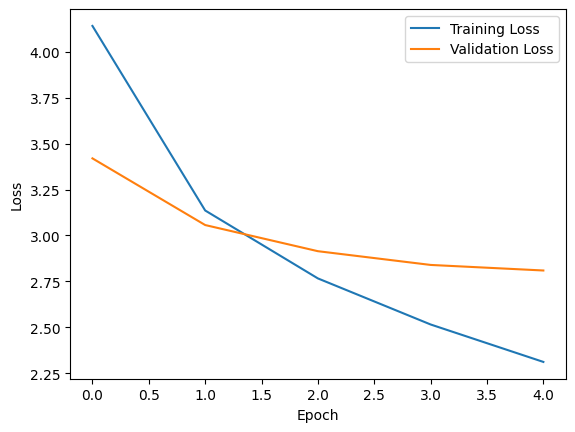

In [33]:
num_epochs = 5
criterion = nn.CrossEntropyLoss()

params = list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr = 0.001)
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    decoder.train()
    
    train_loss = 0
    for i, (features, captions, lengths) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = decoder(features, captions,lengths)
        
        packed_targets = pack_padded_sequence(captions, lengths, batch_first = True)[0]
        
        loss = criterion(outputs, packed_targets)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    decoder.eval()
    
    valid_loss = 0
    with torch.no_grad():
        for i, (features, captions, lengths) in enumerate(valid_loader):
            
            outputs = decoder(features, captions,lengths)
            packed_targets = pack_padded_sequence(captions, lengths, batch_first = True)[0]
            loss = criterion(outputs, packed_targets)
            
            valid_loss += loss.item()
    
    valid_loss /= len(valid_loader)
    valid_losses.append(valid_loss)
    print("Epoch [{}/{}], Training Loss: {:.2f}, Validation Loss: {:.2f}".format(epoch + 1, num_epochs, train_loss, valid_loss))

    

plt.plot(train_losses, label = "Training Loss")
plt.plot(valid_losses, label = "Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [34]:
torch.save(decoder.state_dict(), "decode.pth")

## 4 Generate predictions on test data

I will display 5 sample test images containing different objects, along with the model’s generated captions and all the reference captions for each.

In [35]:
load_model = DecoderRNN(vocab_size = len(all_vocab))
load_model.load_state_dict(torch.load("decode.pth"))

<All keys matched successfully>

Generated Caption: a woman cutting a cake with a knife on it


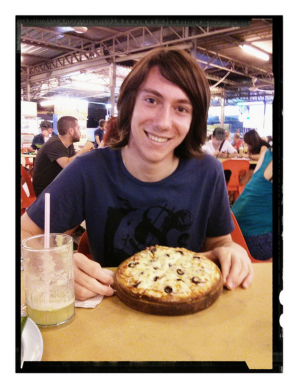

Reference captions:
** There is a man with long hair with a pizza in front of him on the tablr
** A person who is holding a pie in front of them.
** A man with long hair sitting at a table with a pizza. 
** A boy is sitting at a table with a pizza.
** a man is sitting in front of some food at a table


Generated Caption: a zebra standing on a dirt path in a field


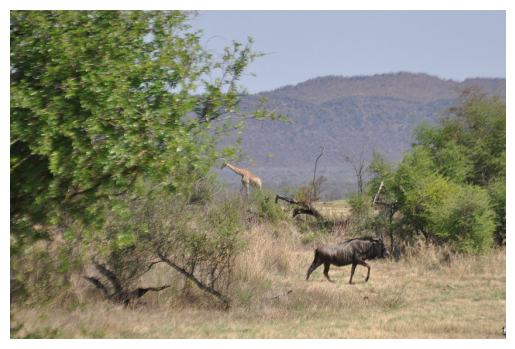

Reference captions:
** A wildebeest walking with a giraffe in the distance.
** A field with various animals, trees, and shrubbery.
** a giraffe in the distance a black animal and some trees
** A wild animal walking across a dry grass filled field.
** A wildebeest walking in a field with a giraffe in the background.


Generated Caption: a red double decker bus driving down a street


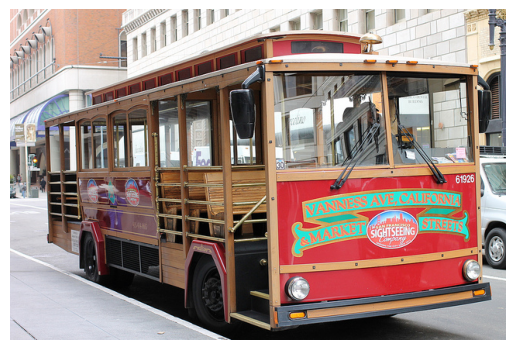

Reference captions:
** A red trolley car driving down a city street.
** An older style trolley bus driving down a city street.
** A red trolley car on the street next to the sidewalk.
** a trolly on a city street near buildings 
** A red sightseeing bus on a California street.


Generated Caption: a cat is standing on a rock in a bathroom


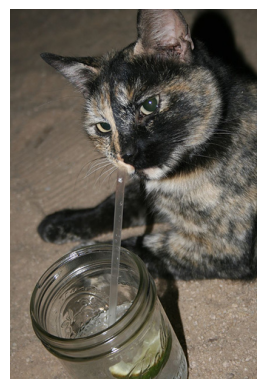

Reference captions:
** a cat lays down next to a glass with a straw in it 
** A cat with a lemon drink in a mason jar with a straw.
** A cat sits next to a glass with a lime in it
** A cat who looks like it is drinking from a straw placed in a mason jar.
** A cat lying in front of a glass on the floor.


Generated Caption: a kitchen with a sink and a refrigerator


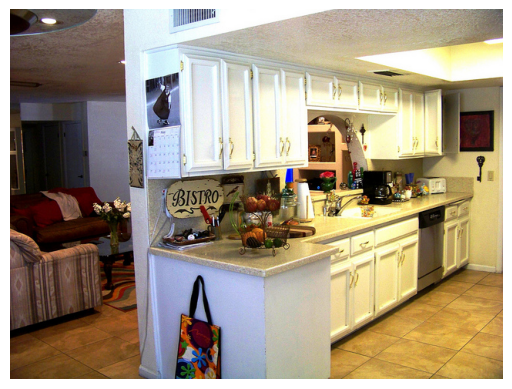

Reference captions:
** A modern kitchen done in white with a living room near by.
** View of half the kitchen and the couches in the living room.
** A living room and a small white kitchen. 
** A calender hangs on the way of a white cabinet kitchen. 
** There is an opening in the kitchen wall through which food can be passed to the living room.




In [38]:
image_paths = test_data["filename"].tolist()
selected_img_pth = random.sample(image_paths, 5)

load_model.eval()

# display images and captions
for image_path in selected_img_pth:
    # load image and extract features
    image = Image.open(IMAGE_DIR + image_path)
    img_id = os.path.splitext(image_path)[0]
    image_features = torch.from_numpy(saved_feat[img_id]).unsqueeze(0)

    # generate caption
    generated_caption = load_model.sample(image_features)
    generated_caption = generated_caption[0].cpu().numpy()
    
    sampled_caption = []
    for word_id in generated_caption:
        word = all_vocab.idx2word[word_id]
        if word == "<end>":
            break
        sampled_caption.append(word)
        
    final_caption = " ".join(sampled_caption)
    
    # display generated caption
    print("Generated Caption: {}".format(final_caption))
    # display image and captions
    plt.imshow(image)
    plt.axis("off")
    plt.show()

    reference_captions = test_data[test_data["filename"] == image_path]["caption"].tolist()
    print("Reference captions:")
    for caption in reference_captions:
        print("** " + caption)
    print("\n")

## 5 Caption evaluation using BLEU score

There are different methods for measuring the performance of image to text models. I will evaluate my model by measuring the text similarity between the generated caption and the reference captions, using two commonly used methods. The first method is known as *Bilingual Evaluation Understudy (BLEU)*.

> 5.1 Average BLEU score on all data

> 5.2 Examplaire high and low score BLEU score samples

####  5.1 Average BLEU score on all data


One common way of comparing a generated text to a reference text is using BLEU. This article gives a good intuition to how the BLEU score is computed: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/, and you may find an implementation online to use. One option is the NLTK implementation `nltk.translate.bleu_score` here: https://www.nltk.org/api/nltk.translate.bleu_score.html


> **Note:** BLEU scores can be weighted by ith-gram. Check that your scores make sense; and feel free to use a weighting that best matches the data. I will not be looking for specific score ranges; rather I will check that the scores are reasonable and meaningful given the captions.

In [39]:
# create the test dataset
test_dataset = COCO_Features(test_data, saved_feat, all_vocab)

# create the data loader for the test dataset
test_loader = DataLoader(dataset = test_dataset, batch_size = 1, shuffle = False, collate_fn = caption_collate_fn)

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
stats = pd.DataFrame(columns = ["ref", "preds", "bleu"])

for i, (image, caption, length) in enumerate(test_loader):
    image_paths = test_data["filename"].tolist()
    image_path = image_paths[i]
    generated_caption = load_model.sample(image)
    generated_caption = generated_caption[0].cpu().numpy()
    
    sample_caption = []
    for word_id in generated_caption:
        word = all_vocab.idx2word[word_id]
        if word == "<end>":
            break
        sample_caption.append(word)
        
    final_caption = " ".join(sample_caption)
    reference_captions = test_data[test_data["filename"] == image_path]["caption"].tolist()
    ref_cap = [caption.split() for caption in reference_captions]
    bleu_score = sentence_bleu(ref_cap, final_caption.split(), weights = (1, 0, 0, 0))

    stats = stats.append({"ref": reference_captions, "preds": final_caption, "bleu": bleu_score}, ignore_index = True)




Average BLEU score: 0.5486699208051303


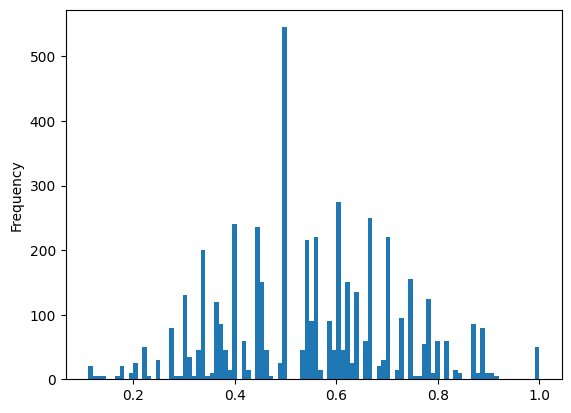

In [42]:
print("Average BLEU score:", stats["bleu"].mean())
ax = stats["bleu"].plot.hist(bins = 100)

#### 5.2 Examplaire high and low score BLEU score samples

I will find one sample with high BLEU score and one with a low score, and display the model's predicted sentences, the BLEU scores, and the 5 reference captions.

In [43]:
# Find the index of the highest and lowest BLEU scores in stats
max_index = stats["bleu"].idxmax()
min_index = stats["bleu"].idxmin()

# Print out the model's predicted sentence, BLEU score, and the 5 reference captions for the highest BLEU score
print("Sample with highest BLEU score:")
print("Predicted sentence:", stats["preds"][max_index])
print("BLEU score:", stats["bleu"][max_index])
print("Reference captions:")
for i in range(5):
    print(stats["ref"][max_index][i])
print()

# Print out the model's predicted sentence, BLEU score, and the 5 reference captions for the lowest BLEU score
print("Sample with lowest BLEU score:")
print("Predicted sentence:", stats["preds"][min_index])
print("BLEU score:", stats["bleu"][min_index])
print("Reference captions:")
for i in range(5):
    print(stats["ref"][min_index][i])


Sample with highest BLEU score:
Predicted sentence: a bathroom with a sink and a mirror
BLEU score: 1.0
Reference captions:
Doorway view into a bathroom with a sink, toilet and mirror.
A mall bathroom with vanity, mirror and toilet.
a bath room with a toilet a mirror and a sink
a small bathroom with a toilet sink and mirror
a really fancy bathroom that is totally clean

Sample with lowest BLEU score:
Predicted sentence: a <unk> of <unk> <unk> <unk> <unk> <unk> <unk>
BLEU score: 0.11111111111111109
Reference captions:
There are four fruits balanced on the neck of the bottle.
A  bottle with fruit balanced on top of it
A wine bottle that has fruit on top of it.
A glass bottle filled with fruits stacked on top of each other.
A bottle with different fruits balanced on top of it.


## 6 Caption evaluation using cosine similarity

> 6.1 Cosine similarity

> 6.2 Cosine similarity examples

####  6.1 Cosine similarity

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions: 

* Find the embedding vector of each word in the caption 
* Compute the average vector for each caption 
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores 

I will then calculate the cosine similarity using the model's predictions over the whole test set. 

In [ ]:
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
stats_cos = pd.DataFrame(columns = ["ref", "preds", "cos_sim"])

def calculate_cosine_similarity(vec1, vec2):
    return cosine_similarity(vec1.reshape(1, -1), vec2.reshape(1, -1))[0][0]

cosine_scores = []

for i, (image, caption, length) in enumerate(test_loader):
    # extract image paths
    image_paths = test_data["filename"].tolist()
    image_path = image_paths[i]

    # generate caption
    generated_caption = load_model.sample(image)
    generated_caption = generated_caption[0].cpu().numpy()

    sample_caption = []
    for word_id in generated_caption:
        word = all_vocab.idx2word[word_id]
        if word == "<end>":
            break
        sample_caption.append(word)

    final_caption = " ".join(sample_caption)

    # compare generated caption with reference captions
    reference_captions = test_data[test_data["filename"] == image_path]["caption"].tolist()

    # calculate cosine similarity for each reference caption
    cosine_scores_per_sample = []
    for reference_caption in reference_captions:
        
        # convert words to indices
        generated_indices = [all_vocab.word2idx.get(word, all_vocab.word2idx["<unk>"]) for word in final_caption.split()]
        reference_indices = [all_vocab.word2idx.get(word, all_vocab.word2idx["<unk>"]) for word in reference_caption.split()]

        # compute the average vectors for generated and reference captions
        generated_vec = torch.mean(load_model.embed(torch.tensor(generated_indices)), dim = 0)
        reference_vec = torch.mean(load_model.embed(torch.tensor(reference_indices)), dim = 0)

        # detach tensors and convert to NumPy arrays
        generated_vec = generated_vec.detach().numpy()
        reference_vec = reference_vec.detach().numpy()

        # compute the cosine similarity score
        cosine_similarity_score = calculate_cosine_similarity(generated_vec, reference_vec)
        cosine_scores_per_sample.append(cosine_similarity_score)

    # compute the average cosine similarity score for the sample
    average_cosine_similarity = sum(cosine_scores_per_sample) / len(cosine_scores_per_sample)
   
    cosine_scores.append(average_cosine_similarity)
    stats_cos = stats_cos.append({"ref": reference_captions, "preds": final_caption, "cos_sim": average_cosine_similarity}, ignore_index = True)


Average BLEU score: 0.3310087268767142


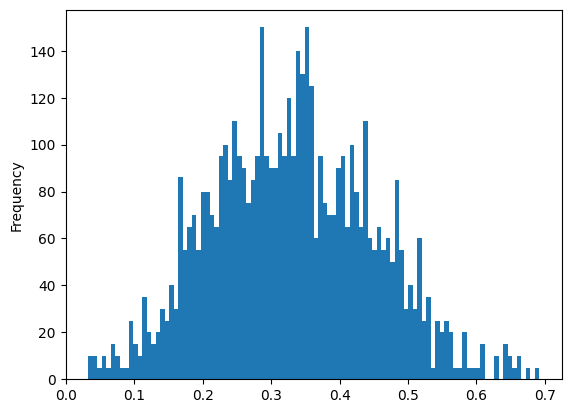

In [45]:
print("Average BLEU score:", stats_cos["cos_sim"].mean())
ax = stats_cos["cos_sim"].plot.hist(bins = 100)

#### 6.2 Cosine similarity examples

I will find one sample with high cosine similarity score and one with a low score, and display the model's predicted sentences, the cosine similarity scores, and the 5 reference captions.

In [46]:
# Find the index of the highest and lowest BLEU scores in stats
max_index = stats_cos["cos_sim"].idxmax()
min_index = stats_cos["cos_sim"].idxmin()
# Print out the model's predicted sentence, BLEU score, and the 5 reference captions for the highest BLEU score
print("Sample with highest Cosine similarity score:")
print("Predicted sentence:", stats_cos["preds"][max_index])
print("Cosine similarity score:", stats_cos["cos_sim"][max_index])
print("Reference captions:")
for i in range(5):
    print(stats_cos["ref"][max_index][i])
print()

# Print out the model's predicted sentence, BLEU score, and the 5 reference captions for the lowest BLEU score
print("Sample with lowest Cosine similarity score:")
print("Predicted sentence:", stats_cos["preds"][min_index])
print("Cosine similarity score:", stats_cos["cos_sim"][min_index])
print("Reference captions:")
for i in range(5):
    print(stats_cos["ref"][min_index][i])


Sample with highest Cosine similarity score:
Predicted sentence: a <unk> of <unk> and a <unk> of <unk>
Cosine similarity score: 0.6915140867233276
Reference captions:
Assorted vases sitting on a shelf in front of a pink wall.
A selection of glass vases sit together in a display.
The vase's displayed come in varying shapes, sizes & colors.
A series of different shaped vases sitting next to each other on display. 
There is a group of oddly shaped vases

Sample with lowest Cosine similarity score:
Predicted sentence: a man is standing on a sidewalk near a parking meter
Cosine similarity score: 0.03269895389676094
Reference captions:
Church with high spire near mountains, capped tops all around
A church tower view with a snow covered mountain behind it.
A church bell tower in the snowy mountains.
Brick steeple seen next to snow covered hillsides.
The bell tower of a church made of rocks with snow covered mountains behind it.


## 7 Comparing BLEU and Cosine similarity

> 7.1 Test set distribution of scores

> 7.2 Analysis of individual examples

#### 7.1 Test set distribution of scores

I will compare the model’s performance on the test set evaluated using BLEU and cosine similarity and discuss some weaknesses and strengths of each method.

Note, to compare the average test scores, you need to rescale the Cosine similarity scores [-1 to 1] to match the range of BLEU method [0.0 - 1.0].

In [47]:
bleu_scores = stats["bleu"].tolist()
cosine_scores = stats_cos["cos_sim"].tolist()
cosine_scores_rescaled = [(score + 1)/2 for score in cosine_scores]

average_bleu_score = sum(bleu_scores) / len(bleu_scores)
average_cosine_score = sum(cosine_scores_rescaled) / len(cosine_scores_rescaled)

print("Average BLEU score on test set: ", average_bleu_score)
print("Average rescaled cosine similarity score on test set: ", average_cosine_score)

Average BLEU score on test set:  0.5486699208051289
Average rescaled cosine similarity score on test set:  0.6655043634383585


 #### 7.2 Analysis of individual examples
 
I will find and display one example where both methods give similar scores and another example where they do not. I will include both scores, predicted captions, and reference captions.

In [51]:
stats_3 = stats.copy()
stats_3["cos_sim"] = stats_cos["cos_sim"]
stats_3["score_diff"] = abs(stats["bleu"] - stats_cos["cos_sim"])
sorted_stats = stats_3.sort_values("score_diff", ascending = False)

similar_scores = sorted_stats[sorted_stats["score_diff"] < 0.1].iloc[[0]]
different_scores = sorted_stats[sorted_stats["score_diff"] > 0.5].iloc[[0]]

# Display captions and scores for similar scores example
print("Example with similar scores:")
print(f"Reference captions: {similar_scores['ref'].values[0]}")
print(f"Generated caption: {similar_scores['preds'].values[0]}")
print(f"BLEU score: {similar_scores['bleu'].values[0]:.2f}")
print(f"Cosine similarity score: {similar_scores['cos_sim'].values[0]:.2f}")

# Display captions and scores for different scores example
print("Example with different scores:")
print(f"Reference captions: {different_scores['ref'].values[0]}")
print(f"Generated caption: {different_scores['preds'].values[0]}")
print(f"BLEU score: {different_scores['bleu'].values[0]:.2f}")
print(f"Cosine similarity score: {different_scores['cos_sim'].values[0]:.2f}")

Example with similar scores:
Reference captions: ['Several people and the handler are sitting atop an elephant.', 'many people are riding on an elephant and some other people are watching ', 'Men and children are sitting atop a large elephant.', 'A group of people riding on the back of an elephant.', 'People riding on a elephant and other people watching them ride.']
Generated caption: a man riding a horse in a carriage on a street
BLEU score: 0.27
Cosine similarity score: 0.17
Example with different scores:
Reference captions: ['A skier stands in front of some trees in the snow. ', 'The man is walking up the ski slope.', 'A single skier standing on ski slope next to trees', 'A skier is stopped at the top of a hill.', 'A person standing on the snow with skis on, next to a patch of trees.']
Generated caption: a person on skis in the snow with skis
BLEU score: 0.89
Cosine similarity score: 0.23
